# A/B Test

---------

## Library

In [1]:
import kagglehub
import os
import pandas as pd
import numpy as np
import warnings
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import set_matplotlib_hangul # 한글 폰트 변환
import Analysis_plot as ap # 시각화 함수
import scipy.stats as stats

Hangul OK in your MAC!


In [2]:
warnings.filterwarnings('ignore', category=FutureWarning)

# Download latest version
path = kagglehub.dataset_download("zhangluyuan/ab-testing")
print(os.listdir(path)) # 다운로드된 파일 목록 확인

['ab_data.csv']


In [3]:
df = pd.read_csv(os.path.join(path, 'ab_data.csv'))
# df.to_csv("../data/AB-Test.csv")
df

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1
...,...,...,...,...,...
294473,751197,2017-01-03 22:28:38.630509,control,old_page,0
294474,945152,2017-01-12 00:51:57.078372,control,old_page,0
294475,734608,2017-01-22 11:45:03.439544,control,old_page,0
294476,697314,2017-01-15 01:20:28.957438,control,old_page,0


### Step 1: 데이터 전처리

> 이 데이터는 실제 A/B 테스트 결과가 담긴 데이터로서<br>
> 웹사이트 개편을 두고, 새로운 페이지를 일부 사용자에게 보여주고, 기존 페이지를 나머지 사용자에게 보여준 후 전환 여부를 기록한 데이터이다.<br>

In [4]:
# 데이터 타입 확인
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 294478 entries, 0 to 294477
Data columns (total 5 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   user_id       294478 non-null  int64 
 1   timestamp     294478 non-null  object
 2   group         294478 non-null  object
 3   landing_page  294478 non-null  object
 4   converted     294478 non-null  int64 
dtypes: int64(2), object(3)
memory usage: 11.2+ MB


In [5]:
# 결측치 확인
df.isna().sum()

user_id         0
timestamp       0
group           0
landing_page    0
converted       0
dtype: int64

In [6]:
df['timestamp'] = pd.to_datetime(df['timestamp']) # 시계열 변환
df['group'].value_counts() # 그룹별 분포

group
treatment    147276
control      147202
Name: count, dtype: int64

### Step 2: EDA

> 이제 본격적으로 A/B 테스트를 진행하기 전에, 데이터의 전반적인 특성과 핵심 지표인 ‘전환율’을 먼저 살펴보려 한다.<br>
> 각 그룹별 전환율을 확인하면, 기존 페이지와 신규 페이지 간의 성과 차이를 직관적으로 파악할 수 있다.<br>
> 여기서 전환율이란, 전체 방문자 중 실제 전환(구매, 회원가입)으로 이어진 비율을 의미한다.<br>
> 이를 통해 두 그룹 간 기본적인 차이를 시각적으로 확인하고, 이후 통계적 검정을 위한 기초 분석 자료로 활용할 수 있다.<br>
> A/B Test에서는 이러한 EDA과정이 사전 진단 역할을 한다는 점에서 매우 중요하다.


treatment 그룹 수: 147276
control 그룹 수: 147202


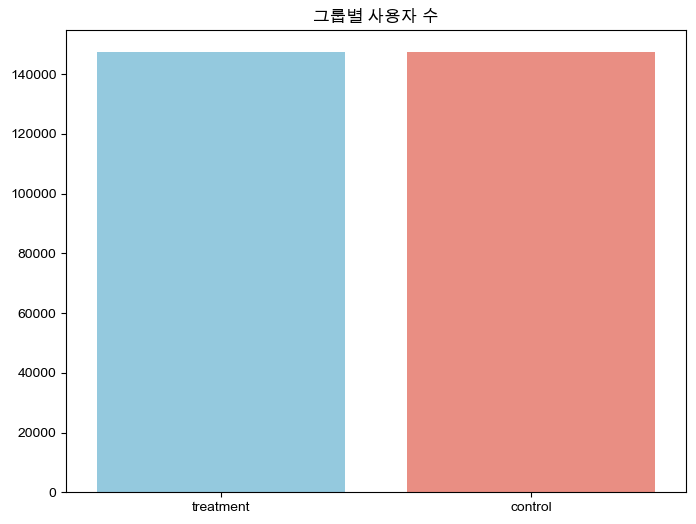

In [7]:
# 그룹별 수
group_count = df['group'].value_counts().reset_index()
group_count.columns = ['group', 'count']

treatment_count = group_count[group_count['group'] == 'treatment']['count'].values[0]
control_count = group_count[group_count['group'] == 'control']['count'].values[0]

print(f"treatment 그룹 수: {treatment_count}")
print(f"control 그룹 수: {control_count}")

# 시각화
ap.bar_plot(group_count, x_col='group', y_col='count', figsize=(8, 6), title='그룹별 사용자 수', palette=['skyblue', 'salmon'])

- new_page인 사용자와 old_page인 사용자의 수

new_page 그룹 수: 147239
old_page 그룹 수: 147239


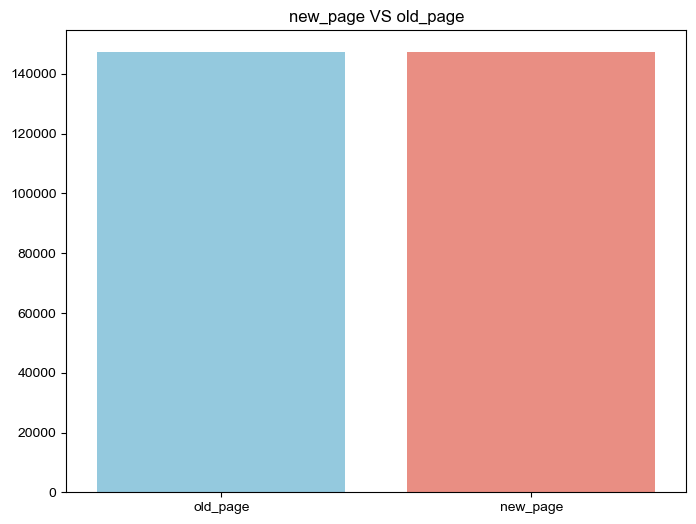

In [8]:
landing_page = df['landing_page'].value_counts().reset_index()
landing_page.columns = ['landing_page', 'count']

new_page = landing_page[landing_page['landing_page'] == 'new_page']['count'].values[0]
old_page = landing_page[landing_page['landing_page'] == 'old_page']['count'].values[0]

print(f"new_page 그룹 수: {new_page}")
print(f"old_page 그룹 수: {old_page}")

# 시각화
ap.bar_plot(landing_page, x_col='landing_page', y_col='count', figsize=(8, 6), title='new_page VS old_page', palette=['skyblue', 'salmon'])

- 그룹별 전환 여부

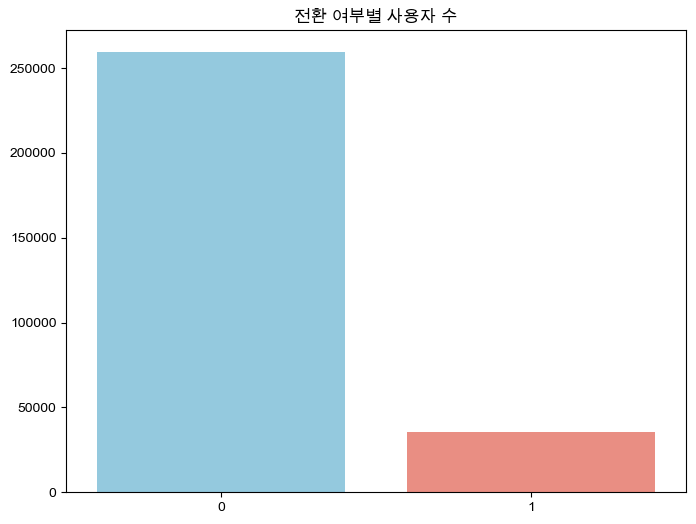

In [9]:
# 그룹별 전환 여부(count)
conversion_counts = df['converted'].value_counts().reset_index()
conversion_counts.columns = ['converted', 'count']

# 시각화
ap.bar_plot(conversion_counts, x_col='converted', y_col='count', figsize=(8, 6), title='전환 여부별 사용자 수', palette=['skyblue', 'salmon'])

- 날짜별 전환율 추이

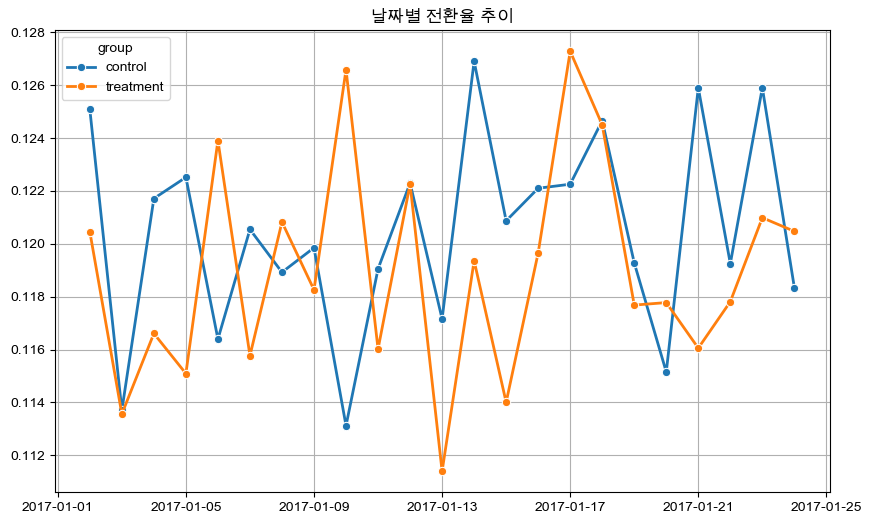

In [10]:
df['date'] = df['timestamp'].dt.date
daily_conversion = df.groupby(['date', 'group'])['converted'].mean().reset_index()

# 시각화
ap.line_plot(daily_conversion, x_col='date', y_col='converted', hue='group', figsize=(10, 6), title='날짜별 전환율 추이')

- 위 EDA 결과 전체 사용자 중 전환하지 않은 사용자(0)의 비율이 절대적으로 높다는 점이 확인되었다.<br> 
- 이는, 흔히 관찰되는 현상으로, 대부분의 사용자는 단순 방문에 그치고, 실제 전환까지 이어지는 경우는 제한적이라는 패턴을 보여준다.<br> 
- 두 그룹 모두 전환율 패턴은 유사하지만, 새로운 페이지가 실제 전환율 개선에 효과적인지 검증이 필요하다.<br>
- 결국, 그룹 간 전환율 차이가 통계적으로 유의미한지 여부가 이번 A/B 테스트의 핵심이다.

In [11]:
df.head()

,user_id,timestamp,group,landing_page,converted,date
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,2017-01-21
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,2017-01-12
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,2017-01-11
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,2017-01-08
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,2017-01-21


### Step 3: 통계적 유의성 검정

> A/B 테스트의 핵심은 단순 수치 비교가 아니라, 그 차이가 우연이 아닌 통계적으로 유의미한 차이인지를 검증하는 데 있다.<br>
> 연속형 지표 비교 (매출, 체류시간 등): 정규성 검정 → t-test 또는 U-test<br>
> 범주형 지표 비교 (전환 여부, 클릭 여부 등): 빈도표 생성 → 카이제곱 검정 or Z-test<br>
> 현재 데이터는 ‘전환 여부’가 핵심이므로 카이제곱 검정으로 진행하는 게 정석이다.<br>
> 또한 위 EDA 결과 아래와 같이 가설을 세울 수 있다.<br>
> - 1.control 그룹의 전환율보다 treatment 그룹의 전환율이 더 높을 것이다.
> - 2.old_page 그룹의 전환율보다 new_page 그룹의 전환율이 더 높을 것이다.

In [12]:
# 카이제곱 검정
def chi_square_test(df, group_col, target_col):
    cross_table = pd.crosstab(df[group_col], df[target_col]) # 교차 table 생성
    stat, p, _, _ = stats.chi2_contingency(cross_table) # 카이제곱 검증

    print(f"카이제곱 통계량: {stat:.4f}, p-value: {p:.4f}")

    if p < 0.05:
        print("귀무가설 기각: 두 그룹 간 유의미한 차이가 있다.")
    else:
        print("귀무가설 기각 불가: 두 그룹 간 유의미한 차이가 없다.")

- 가설 1

카이제곱 통계량: 1.5160, p-value: 0.2182
귀무가설 기각 불가: 두 그룹 간 유의미한 차이가 없다.


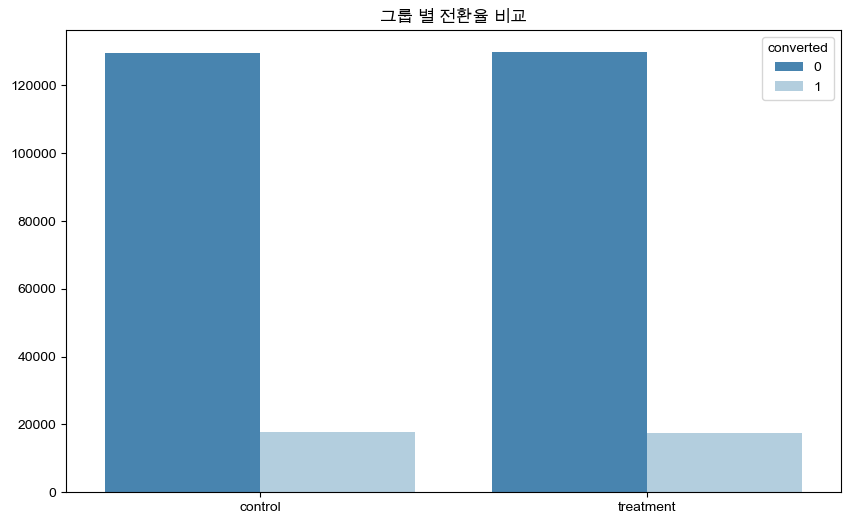

In [13]:
group = df.groupby(['group', 'converted']).size().reset_index(name='count')

chi_square_test(df, 'group', 'converted')
ap.bar_plot(group, x_col='group', y_col='count', hue='converted', figsize=(10, 6), title='그룹 별 전환율 비교')

- 가설 2

카이제곱 통계량: 1.8568, p-value: 0.1730
귀무가설 기각 불가: 두 그룹 간 유의미한 차이가 없다.


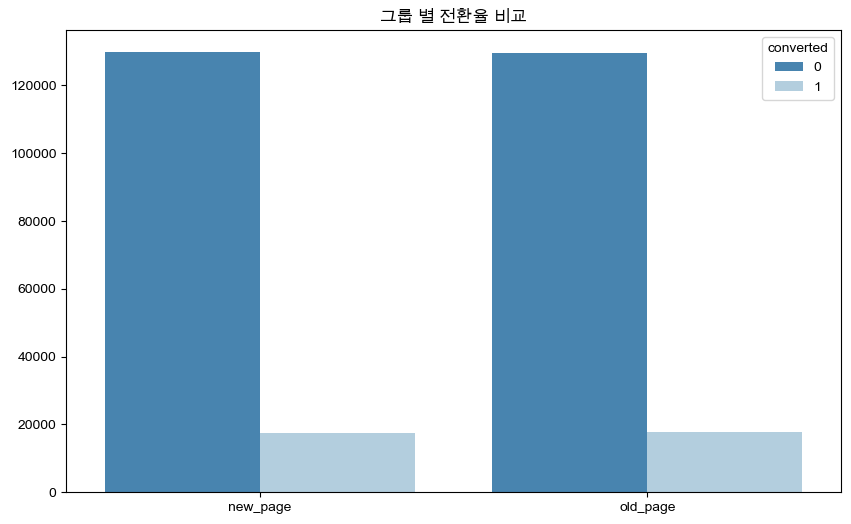

In [14]:
landing = df.groupby(['landing_page', 'converted']).size().reset_index(name='count')

chi_square_test(df, 'landing_page', 'converted')
ap.bar_plot(landing, x_col='landing_page', y_col='count', hue='converted', figsize=(10, 6), title='그룹 별 전환율 비교')

## 결론

> 위 검증 결과 p-value < 0.05 임으로 두 그룹 모두 유의미한 차이가 없다.<br>
> 따라서, 기존 웹 페이지를 유지하거나, 새로운 웹 페이지를 만들어야한다고 볼 수 있다.